# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [ ]:
import yfinance as yf
from curl_cffi import requests
import pandas as pd
session = requests.Session(impersonate="chrome")
aapl_df = yf.download("AAPL", session  = session)

[*********************100%***********************]  1 of 1 completed


In [18]:
aapl_df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1980-12-12,0.098597,0.099025,0.098597,0.098597,469033600
1980-12-15,0.093453,0.093881,0.093453,0.093881,175884800
1980-12-16,0.086594,0.087022,0.086594,0.087022,105728000
1980-12-17,0.088737,0.089165,0.088737,0.088737,86441600
1980-12-18,0.091310,0.091738,0.091310,0.091310,73449600


In [ ]:
import yfinance as yf
import pandas as pd

stocks_to_buy = [
    "MSFT","NVDA","AAPL","GOOG","AMZN","META",

    "AVGO","BRK-A","WMT","JPM","V","MA","XOM"
]


close_df = yf.download(
    tickers=stocks_to_buy,
    start="2020-01-01",
    end="2025-06-20",session= session
)[ "Close" ]


close_df.index.name = "Date"
close_df.rename(columns={"BRK.A":"BRK-A"}, inplace=True)

close_df = close_df.reset_index()

print(close_df.head())


[*********************100%***********************]  13 of 13 completed


Ticker       Date       AAPL       AMZN       AVGO     BRK-A       GOOG  \
0      2020-01-02  72.620842  94.900497  27.901752  342261.0  67.964508   
1      2020-01-03  71.914818  93.748497  27.192070  339155.0  67.630989   
2      2020-01-06  72.487839  95.143997  27.151394  340210.0  69.298584   
3      2020-01-07  72.146942  95.343002  27.057922  338901.0  69.255325   
4      2020-01-08  73.307510  94.598503  26.720394  339188.0  69.801094   

Ticker         JPM          MA        META        MSFT      NVDA           V  \
0       120.733574  294.123138  208.635391  153.042313  5.971747  183.872040   
1       119.140297  291.253571  207.531494  151.136627  5.876163  182.409698   
2       119.045578  292.029144  211.440048  151.527298  5.900805  182.015244   
3       117.021729  291.040314  211.897507  150.145721  5.972245  181.534180   
4       117.934624  296.175598  214.045731  152.537323  5.983446  184.641678   

Ticker        WMT        XOM  
0       36.593372  54.634789  
1     

In [26]:
close_df.set_index("Date")
close_df.to_csv("MiniProj1Data.csv")

In [48]:
close_df.columns

Index(['Date', 'AAPL', 'AMZN', 'AVGO', 'BRK-A', 'GOOG', 'JPM', 'MA', 'META',
       'MSFT', 'NVDA', 'V', 'WMT', 'XOM'],
      dtype='object', name='Ticker')

In [ ]:
import numpy as np
from scipy.optimize import minimize


close_df['Date'] = pd.to_datetime(close_df['Date'])
close_df.set_index('Date', inplace=True)


start = close_df.index.min()
end_3m = start + pd.DateOffset(months=3)
train_df = close_df.loc[start:end_3m]

rets = train_df.pct_change().dropna()


mu    = rets.mean() * 252                
Sigma = rets.cov()  * 252                

n   = len(mu)                      
w0  = np.ones(n) / n
bnds = tuple((0,1) for _ in range(n))
cons = ({'type':'eq', 'fun': lambda w: np.sum(w)-1})

Sigma_mat = Sigma.values                 
def port_var(w):
    return w @ Sigma_mat @ w       


res = minimize(
    port_var, w0,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)

w_minvar = res.x
print("Min-Var Weights:", w_minvar)


Min-Var Weights: [6.94375823e-17 4.71351734e-01 0.00000000e+00 2.69149531e-01
 0.00000000e+00 1.64223805e-17 0.00000000e+00 0.00000000e+00
 4.03689355e-17 9.98897644e-17 8.09704852e-18 2.59498735e-01
 0.00000000e+00]


In [50]:
def neg_sharpe(w, mu, Sigma, rf):
    ret = w.T @ mu
    vol = np.sqrt(w.T @ Sigma @ w)
    return -(ret - rf) / vol

res_tangency = minimize(
    neg_sharpe, w0,
    args=(mu, Sigma, rf),
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
w_tan = res_tangency.x
print("Max-Sharpe Weights:", w_tan)


Max-Sharpe Weights: [4.30211422e-16 1.11022302e-16 1.52655666e-16 0.00000000e+00
 0.00000000e+00 2.91433544e-16 5.13478149e-16 7.77156117e-16
 1.24900090e-16 1.00000000e+00 4.16333634e-17 1.11022302e-16
 0.00000000e+00]


In [ ]:
target_vol = 0.15

cons_risk = (
    {'type': 'eq',   'fun': lambda w: np.sum(w) - 1},
    {'type': 'ineq','fun': lambda w: target_vol - np.sqrt(w.T @ Sigma @ w)}
)

res_maxret = minimize(
    lambda w: - (w.T @ mu), 
    w0,
    method='SLSQP',
    bounds=bnds,
    constraints=cons_risk
)
w_maxret = res_maxret.x
print(f"Max-Return for σ≤{target_vol:.2%} Weights:", w_maxret)


Max-Return for σ≤15.00% Weights: [6.40923681e-14 4.71174426e-01 6.79299127e-13 2.68216171e-01
 1.00188030e-14 2.56958305e-15 7.63602183e-13 1.35790007e-12
 2.54499741e-12 1.24476227e-12 1.86937904e-12 2.60609414e-01
 8.41333840e-14]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


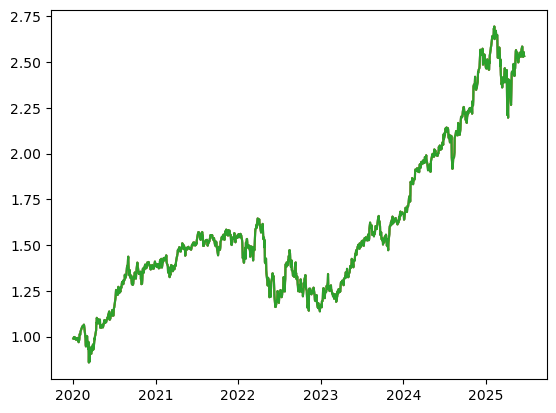

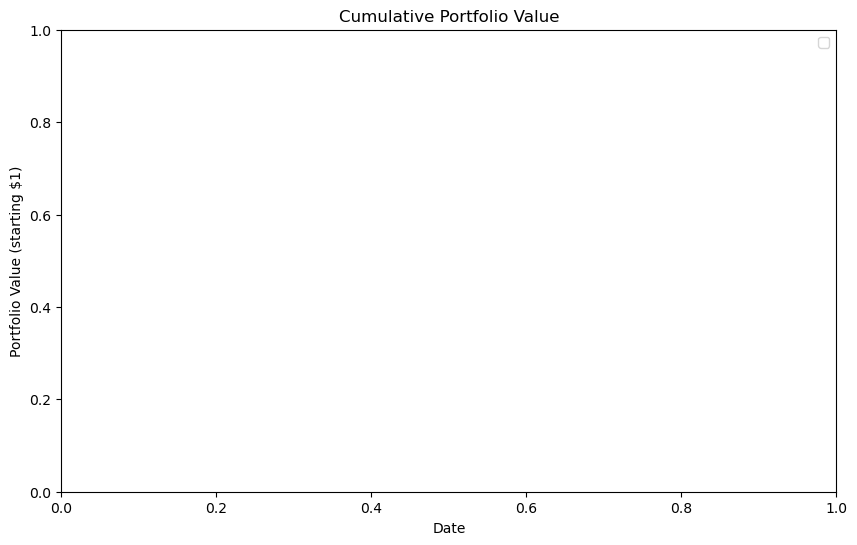

In [ ]:
import matplotlib.pyplot as plt
labels = ["Minimum Variance", "Max Sharpe", ".15Variance"]
return_array = [w_minvar,w_tan, w_maxret]
for rets, label in zip(return_array, labels):

    rets = close_df.pct_change().dropna()      # shape (T, N)


    portfolio_rets = rets.dot(w_maxret)

    cum_value = (1 + portfolio_rets).cumprod()
    plt.plot(cum_value.index, cum_value, label=label)

# 4) plot
plt.figure(figsize=(10,6))

plt.ylabel('Portfolio Value (starting $1)')
plt.xlabel('Date')
plt.title('Cumulative Portfolio Value')
plt.legend()
plt.show()


Returns shape: (1372, 13)
Weight lengths: [13, 13, 13]
Min-Var cumulative head:
 Date
2020-01-03    0.989545
2020-01-06    0.996794
2020-01-07    0.994347
2020-01-08    0.990029
2020-01-09    0.998124
dtype: float64
Min-Var cumulative tail:
 Date
2025-06-12    2.540861
2025-06-13    2.528229
2025-06-16    2.554035
2025-06-17    2.536797
2025-06-18    2.532497
dtype: float64


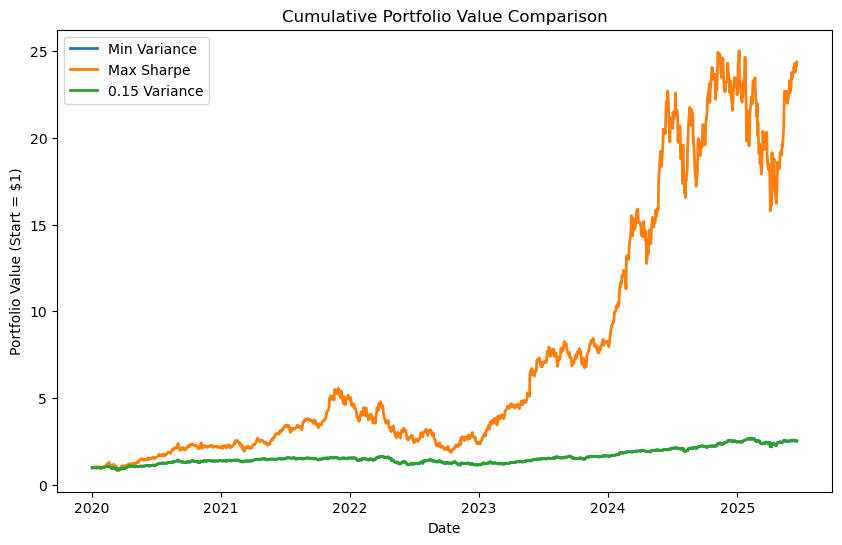

In [ ]:


labels  = ["Min Variance", "Max Sharpe", "0.15 Variance"]
weights = [w_minvar,      w_tan,        w_maxret]


rets = close_df.pct_change().dropna()   
print("Returns shape:", rets.shape)
print("Weight lengths:", [len(w) for w in weights])
assert rets.shape[1] == len(w_minvar), "Number of assets and weight-length must match"

plt.figure(figsize=(10,6))


for w, label in zip(weights, labels):

    port_rets = rets.dot(w)
  
    cum = (1 + port_rets).cumprod()
    
    
    if label == "Min Variance":
        print("Min-Var cumulative head:\n", cum.head())
        print("Min-Var cumulative tail:\n", cum.tail())
    
    plt.plot(cum.index, cum, label=label, linewidth=2)

# 5) Finalize
plt.title("Cumulative Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Start = $1)")
plt.legend()
plt.show()



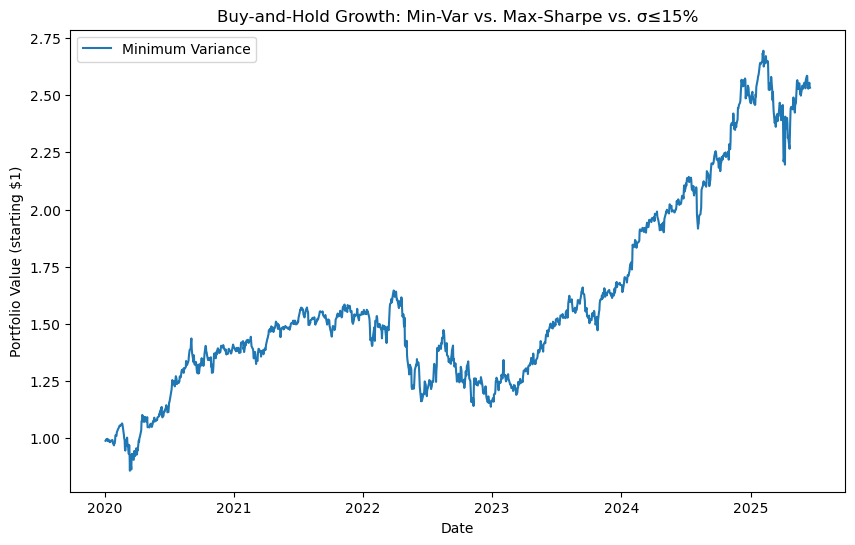

In [ ]:
import matplotlib.pyplot as plt

labels  = ["Minimum Variance"]
weights = [w_minvar]


rets = close_df.pct_change().dropna()   
plt.figure(figsize=(10,6))

for w, label in zip(weights, labels):


    port_rets = rets.dot(w)


    cum_value = (1 + port_rets).cumprod()


    plt.plot(cum_value.index, cum_value, label=label)

plt.ylabel('Portfolio Value (starting $1)')
plt.xlabel('Date')
plt.title('Buy-and-Hold Growth: Min-Var vs. Max-Sharpe vs. σ≤15%')
plt.legend()
plt.show()